# Classify Medical Specialities based on Transcription text

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


import nltk #Natural language toolkit
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer  # Tokenize
tokenizer = RegexpTokenizer(r'\w+')  #drop everything besides alphanumeric characters
from nltk.corpus import stopwords   #Stopwords
stopwords = set(stopwords.words('english'))
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()


In [2]:
# load file
df = pd.read_csv('mtsamples.csv', index_col = 0)
print(df.shape)
df.head()

(4999, 5)


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
## missing values
df.isnull().sum()

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

## Distribution of Medical Specialities/Labels

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

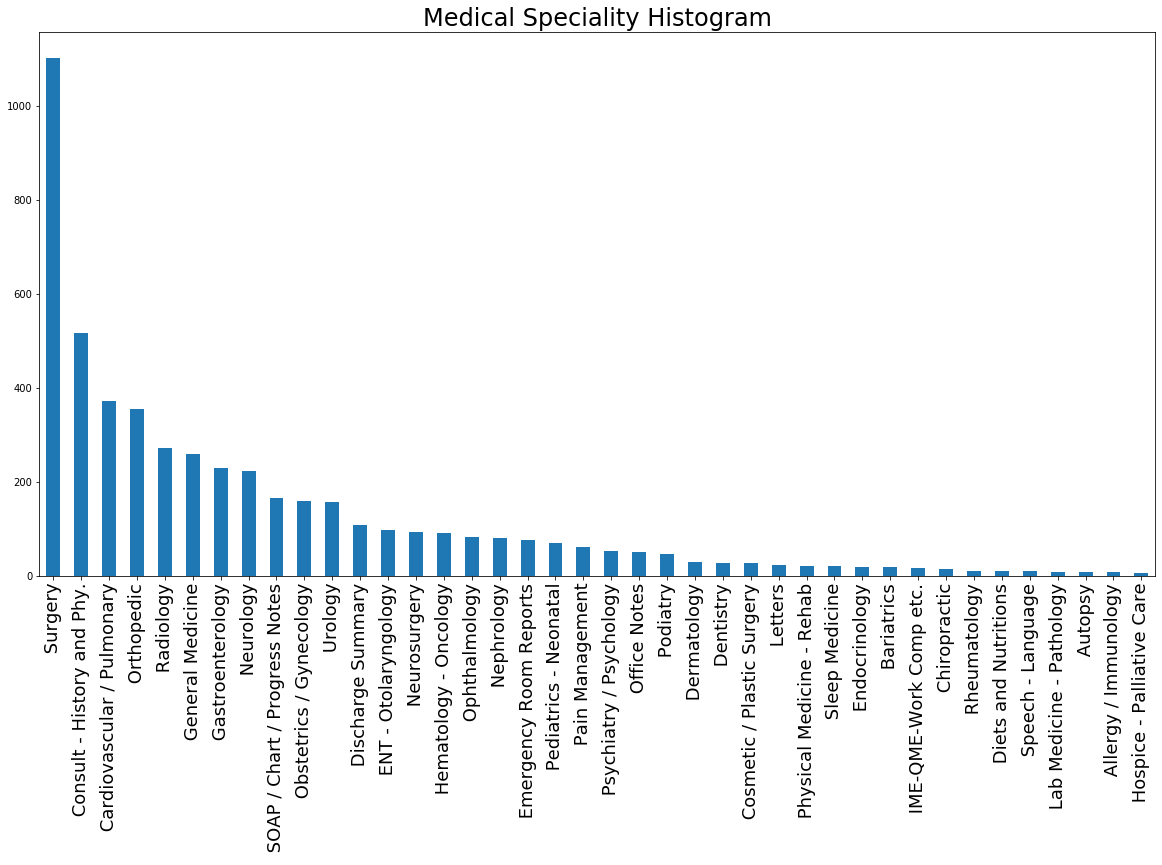

In [4]:
x = df['medical_specialty'].value_counts()
print(x)
print(type(x))
plt.figure(figsize = (20,10))
plt.title('Medical Speciality Histogram',fontsize = 24)
x.plot(kind = 'bar')
plt.xticks(fontsize = 18,rotation ='vertical')
plt.show()

#### substantial difference in top medical speciality and the second top medical speciality. Long tail or log distribution. Indication of class imbalance. 
#### This is a good example for why measuring model performance with Accuracy is not a good idea and measures like F1, Sensitivity and Specifity are important. 

In [5]:
# viewing the missing transcription records.
df[df['transcription'].isnull()]

,description,medical_specialty,sample_name,transcription,keywords
97,Inguinal orchiopexy procedure.,Urology,Inguinal orchiopexy,NaN,"urology, inguinal orchiopexy, keith needles, a..."
116,Inguinal hernia hydrocele repair.,Urology,Hydrocele Repair,NaN,"urology, inguinal hernia, external oblique, he..."
205,Vaginal Hysterectomy. A weighted speculum wa...,Surgery,Vaginal Hysterectomy,NaN,"surgery, omentum, massachusetts, vaginal hyste..."
263,Total Abdominal Hysterectomy (TAH). An incis...,Surgery,Total Abdominal Hysterectomy,NaN,"surgery, fundus, double-toothed tenaculum, mus..."
459,Parotidectomy procedure,Surgery,Parotidectomy,NaN,"surgery, parotidectomy, mixter clamp, auditory..."
622,Laparoscopy. The cervix was grasped with a s...,Surgery,Laparoscopy - 1,NaN,"surgery, uterus, cervix, vaginal, single tooth..."
628,Laparoscopy. An incision was made in the umb...,Surgery,Laparoscopy - 2,NaN,"surgery, umbilicus, trocar, falope, laparoscop..."
680,Inguinal orchiopexy procedure.,Surgery,Inguinal orchiopexy,NaN,"surgery, inguinal orchiopexy, keith needles, a..."
729,Inguinal hernia hydrocele repair.,Surgery,Hydrocele Repair,NaN,"surgery, inguinal hernia, external oblique, he..."
871,Common description of EGD,Surgery,EGD Template - 4,NaN,"surgery, lateral supine position, stomach, duo..."


In [6]:
# since transcription is the only feature we are including in analysis, we drop the rows that has no transcription text
df = df.drop(df[df['transcription'].isna()].index)
df.isnull().sum() 

description             0
medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

In [7]:
### Drop rows for low counts of medical speciality. This will make training harder
counts = df['medical_specialty'].value_counts()
df = df[df['medical_specialty'].isin(counts[counts > 50].index)]
df

,description,medical_specialty,sample_name,transcription,keywords
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."
11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler..."
...,...,...,...,...,...
4972,Adenosine with nuclear scan as the patient un...,Cardiovascular / Pulmonary,Adenosine Nuclear Scan,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","cardiovascular / pulmonary, adenosine nuclear ..."
4973,Patient presents with a chief complaint of ch...,Cardiovascular / Pulmonary,Acute Inferior Myocardial Infarction,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",NaN
4974,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a...",NaN
4975,Patient had a markedly abnormal stress test w...,Cardiovascular / Pulmonary,Abnormal Stress Test,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","cardiovascular / pulmonary, standard bruce, ni..."


## Data Preprocessing

### We will only use Transcription data to classify Medical Specialty

In [8]:
### Creating a new dataframe
#df_new = df.copy()
df_new = df[['transcription','medical_specialty']].copy()

#### Tokenizing, stopwords, lemmatization. We are not removing digits from the data. As these digits could be weight, age etc. that many a times helps in diagnoistics

In [9]:
def prepareText(column):
    le = LabelEncoder()
    le.fit(df_new['medical_specialty'])
    df_new.loc[:, 'class_label'] = le.transform(df_new['medical_specialty'])
    # create text label to numeric label mapping, to use later
    labelencoder_mapping = dict(zip(le.classes_, le.transform(le.classes_)))    
    
    #tokenize and replace '-' with '' to account for words like 2-d, m-mode
    df_new[column] = df_new[column].apply(lambda s: tokenizer.tokenize(str(s).replace('-','')))
    #df_new[column] = df_new[column].apply(word_tokenize)
    # stopwords and lowercase
    df_new[column] = df_new[column].apply(lambda s: [w.lower() for w in s if w not in stopwords])
    # lemmatization
    df_new[column] = df_new[column].apply(lambda s: [lemma.lemmatize(w) for w in s])   

    return labelencoder_mapping

## Q. Do we need Dependent variable's categorical values to be transformed to Numeric values -> LabelEncoding on Dependent variable

In [10]:
# feature cleaning and processing, return text label to numeric label mapping
labelencoder_mapping = prepareText('transcription')
labelencoder_mapping


{' Cardiovascular / Pulmonary': 0,
 ' Consult - History and Phy.': 1,
 ' Discharge Summary': 2,
 ' ENT - Otolaryngology': 3,
 ' Emergency Room Reports': 4,
 ' Gastroenterology': 5,
 ' General Medicine': 6,
 ' Hematology - Oncology': 7,
 ' Nephrology': 8,
 ' Neurology': 9,
 ' Neurosurgery': 10,
 ' Obstetrics / Gynecology': 11,
 ' Ophthalmology': 12,
 ' Orthopedic': 13,
 ' Pain Management': 14,
 ' Pediatrics - Neonatal': 15,
 ' Psychiatry / Psychology': 16,
 ' Radiology': 17,
 ' SOAP / Chart / Progress Notes': 18,
 ' Surgery': 19,
 ' Urology': 20}

In [11]:
# drop text label
df_new = df_new.drop(columns ='medical_specialty')


In [12]:
## Stat summary for Transcriptions text

# length of  each transcriptions
print('Stat summary for Transcriptions text: ')
df_new['transcription'].map(lambda v: len(v)).describe()


Stat summary for Transcriptions text: 


count    4597.000000
mean      313.388949
std       195.272808
min         1.000000
25%       167.000000
50%       279.000000
75%       415.000000
max      1583.000000
Name: transcription, dtype: float64

In [13]:
print(df_new['transcription'])


3       [2d, mmode, 1, left, atrial, enlargement, left...
4       [1, the, left, ventricular, cavity, size, wall...
7       [2d, echocardiogram, multiple, view, heart, gr...
9       [description, 1, normal, cardiac, chamber, siz...
11      [2d, study, 1, mild, aortic, stenosis, widely,...
                              ...                        
4972    [indication, chest, pain, type, of, test, aden...
4973    [chief, complaint, chest, pain, history, of, p...
4974    [history, of, present, illness, the, patient, ...
4975    [history, of, present, illness, mr, abc, 60yea...
4976    [reason, for, consultation, abnormal, echocard...
Name: transcription, Length: 4597, dtype: object


## Feature Engineering

#### BAG oF WORDS:  with n-gram from unigram to tri-gram. Reason phrases like left atrial enlargement, history medical illness, chest pain ec....

In [14]:
## BOW with n-gram from unigram to tri-gram 
def BOW(data):
    cv = CountVectorizer(min_df =0.,max_df =1.)
    cv_matrix = cv.fit_transform(data)
    cv_matrix = cv_matrix.toarray()
    return(cv_matrix)

In [15]:
# BOW
def BOW_alternate():
    return CountVectorizer(min_df =0.,max_df =1.)

#### TfIDF

In [16]:
## TF-IDF
def tfidf(data):
    tv = TfidfVectorizer(use_idf = True) #min_df = 0.,max_df = 1.
    tv_matrix = tv.fit_transform(data)
    tv_matrix = tv_matrix.toarray() 
    return(tv_matrix)

In [17]:
# TF-IDF
def tfidf_alternate():
    return TfidfVectorizer(use_idf = True)

## PCA

In [18]:
def PCA_varianceExplained(X):
    pca = PCA().fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

## TruncatedSVD

#### This is very similar to PCA, excepting that the factorization for SVD is done on the data matrix, whereas for PCA, the factorization is done on the covariance matrix. regular SVDs in that it produces a factorization where the number of columns is equal to the specified truncation. For example, given an n x n matrix, SVD will produce matrices with n columns, whereas truncated SVD will produce matrices with the specified number of columns. This is how the dimensionality is reduced.

In [19]:
# find n_components for truncated SVD that explains 95% variance
def tsvd_n_component(X,tsvd_var_ratios):
    
    # set goal and inital variance
    goal_var, total_var = 0.95, 0.0
    
    # set initial number of features
    n_component = 0
    
    # Find explained variance as we add features
    for explained_var in tsvd_var_ratios:
        total_var += explained_var
        n_component += 1
        if total_var >= goal_var:
            break
    return n_component    

## Models

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Random Forest
def rfClassifier():
    return RandomForestClassifier(n_estimators =100,verbose =1)

# LR    
def lrClassifierRegressor():
    return LogisticRegression(solver ='saga',multi_class = 'multinomial', n_jobs = -1)





## SMOTE: Over sampling (Imbalance data)

In [ ]:
from imblearn.over_sampling import SMOTE
def smote(x,y):
    sm = SMOTE(random_state = 41)

    x_res, y_res = sm.fit_sample(x,y)
    unique_elements, counts_elements = np.unique(y_res, return_counts=True)
    print('Oversampling with SMOTE. Medical Speciality Class balance through SMOTE:')
    print(np.asarray((unique_elements, counts_elements)))
    return x_res,y_res

Using TensorFlow backend.


## Train and Test 
#### Training model in two different ways.
#### 1. model(): create feature vector on the whole dataset and then splitting the data into train and test. Using SMOTE to oversample train and then modeling and testing
#### 2. model_alternate(): Splitting train and test. fit_transform feature vector on train and transform test based on trained feature vector, apply SMOTE, modeling and testing

In [ ]:
# This model might lead to data leakage because feature engineering done before train and test split
def model(X,y):

    # Split the train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size = 0.25, shuffle = True)
    
    # How long is the feature vector - Are we going to surfer from Curse of Dimenstionality.
    print('Dimension of feature vector')
    print('No. of Rows: ',X_train.shape[0])
    print('No. of Columns/Size of Feature Vector:', X_train.shape[1],'\n')
   

    # Reduce dimensionality
    # NOTE: PCA doesn't work with sparse matrix. Applying TruncatedSVD
    # TSVD suffers from 'sign indeterminancy' which means every time tsvd is fit to the data, a random state seed and algorithm are used and thus depending on these variables the sign of the output can flip. So, fit once and then use it for transform     
    n_components = 5
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(X_train)
    print('Ratio of explained variance: ',svd.explained_variance_ratio_)
    # cumulative explained variance ratio
    print('Cumulative explained variance ratio')
    print(np.array([svd.explained_variance_ratio_[:i].sum() for i in range(1, n_components+1)]).round(2))

    X_train_transformed = svd.transform(X_train)
    X_test_transformed = svd.transform(X_test)
    
    
    # dimensions reduced
    print('\n Dimensionality Reduction')
    print('No. of Rows: ',X_train_transformed.shape[0])
    print('No. of Columns/Size of Feature Vector:', X_train_transformed.shape[1],'\n')
    
    # smote: SMOTE is not very effective for high dimensional data, tsvd will help
    X_train_res, y_train_res = smote(X_train_transformed,y_train) 
    
     # train model RF
    model_fit_rf = rfClassifier().fit(X_train_res, y_train_res)
   
    # model test
    prediction = model_fit_rf.predict(X_test_transformed)
    scores = model_fit_rf.score(X_test_transformed, y_test)
        
    accuracy = scores 
    precision = precision_score(y_test,prediction,average='micro')
    recall = recall_score(y_test, prediction, average='micro')
    f1 = f1_score(y_test, prediction, average='micro')
    print('Performance for RF')
    print("accuracy:  ",accuracy)
    print("precision: ",precision)
    print("recall:" ,recall)
    print("f1 score: " ,f1)
    
    print('\n \n')
    
     # train model LR
    model_fit_lr = lrClassifierRegressor().fit(X_train_res, y_train_res)
    
    # model test
    prediction = model_fit_lr.predict(X_test_transformed)
    scores = model_fit_lr.score(X_test_transformed, y_test)
        
    # performance measurement
    print('Performance for LR')
    accuracy = scores
    precision = precision_score(y_test,prediction,average='macro')
    recall = recall_score(y_test, prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')
    print("accuracy:  ",accuracy)
    print("precision: ",precision)
    print("recall:" ,recall)
    print("f1 score: " ,f1)

In [ ]:
def model_alternate(X,y,feature_engineer):
    
    X = X.astype(str)
    y = y.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size = 0.25, shuffle = True)
    
    # over sampler won’t be able to handle raw text data. It has to be transformed into a feature space for over sampler to work. I’ll first fit TfidfVectorizer
    # Perform feature engineering first and then smote
    if feature_engineer == 'tfidf':
        tfidf = tfidf_alternate()  
        X_fe = tfidf.fit_transform(X_train)   # tfidf fit and transform on train data
        X_test_fe = tfidf.transform(X_test)       # tfidf transform test data
    elif feature_engineer == 'bow':
        bow = BOW_alternate()
        X_fe = bow.fit_transform(X_train)   # bow fit and transform on train data
        X_test_fe = bow.transform(X_test)       # bow transform test data
    
    
    # How long is the feature vector - Are we going to surfer from Curse of Dimenstionality.
    print('Dimension of feature vector')
    print('No. of Rows: ',X_fe.shape[0])
    print('No. of Columns/Size of Feature Vector:', X_fe.shape[1],'\n')
   

    # Reduce dimensionality
    # NOTE: PCA doesn't work with sparse matrix. Applying TruncatedSVD
    # TSVD suffers from 'sign indeterminancy' which means every time tsvd is fit to the data, a random state seed and algorithm are used and thus depending on these variables the sign of the output can flip. So, fit once and then use it for transform     
    n_components = 5
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(X_fe)
    print('Ratio of explained variance: ',svd.explained_variance_ratio_)
    # cumulative explained variance ratio
    print('Cumulative explained variance ratio')
    print(np.array([svd.explained_variance_ratio_[:i].sum() for i in range(1, n_components+1)]).round(2))

    X_train_transformed = svd.transform(X_fe)
    X_test_transformed = svd.transform(X_test_fe)
    
    #print('Ratio of explained variance: ')
    #explained_variances = np.var(X_train_transformed, axis=0) / np.var(X_fe, axis=0).sum()
    
    # dimensions reduced
    print('\n Dimensionality Reduction')
    print('No. of Rows: ',X_train_transformed.shape[0])
    print('No. of Columns/Size of Feature Vector:', X_train_transformed.shape[1],'\n')
    
    # smote: SMOTE is not very effective for high dimensional data, tsvd will help
    X_train_res, y_train_res = smote(X_train_transformed,y_train)
    
    # train model
    model_fit_rf = rfClassifier().fit(X_train_res, y_train_res)
    
    # model test
    prediction = model_fit_rf.predict(X_test_transformed)
    scores = model_fit_rf.score(X_test_transformed, y_test)
        
    # performance measurement
    accuracy = scores
    precision = precision_score(y_test,prediction,average='macro')
    recall = recall_score(y_test, prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')
    print("accuracy:  ",accuracy)
    print("precision: ",precision)
    print("recall:" ,recall)
    print("f1 score: " ,f1)
    
    
    print('\n \n')
    
     # train model LR
    model_fit_lr = lrClassifierRegressor().fit(X_train_res, y_train_res)
    
    # model test
    prediction = model_fit_lr.predict(X_test_transformed)
    scores = model_fit_lr.score(X_test_transformed, y_test)
        
    # performance measurement
    print('Performance for LR')
    accuracy = scores
    precision = precision_score(y_test,prediction,average='macro')
    recall = recall_score(y_test, prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')
    print("accuracy:  ",accuracy)
    print("precision: ",precision)
    print("recall:" ,recall)
    print("f1 score: " ,f1)
    

In [ ]:
model_alternate(df_new['transcription'],df_new['class_label'],'bow')



In [ ]:
model_alternate(df_new['transcription'],df_new['class_label'],'tfidf')


In [ ]:
X_tfidf = tfidf(df_new['transcription'].astype(str))  
model(X_tfidf,df_new['class_label'].to_numpy())



In [ ]:
X_bow = BOW(df_new['transcription'].astype(str))  
model(X_bow,df_new['class_label'].to_numpy())



## Improving Model Performance
### There might be many reasons why the models are not performing well. Steps that can be taken
### 1. Better Feature engineering: Maybe try LDA topic modeling
### 2. Instead of just SMOTE, apply combination of undersampling and oversampling
### 3. K-cross validation
### 4. SVDs n_components - find component that explains atleast 95% of data variation


In [47]:
#### Feature Engineering: Topic modeling - LDA
from sklearn.decomposition import LatentDirichletAllocation
def lda(data,ntopics = 10):
    docterm_matrix = BOW(data)
    lda = LatentDirichletAllocation(n_topics= ntopics, max_iter=10000, random_state=0)
    
    # pass docterm matrix -> id2word/bow/tfidf matrix tp lda
    dt_matrix = lda.fit_transform(docterm_matrix)
    
    # document topic matrix is the feature vector
    features = pd.DataFrame(dt_matrix, columns = ['C'+str(i) for i in range(ntopics)])

    return features
    #return features, lda

In [ ]:
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
smote_over_sample = SMOTE(sampling_strategy='minority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = smote_over_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")